In [1]:
import sys
from pathlib import Path

# notebooks/ -> project root -> backend
BACKEND_DIR = (Path.cwd().parent / "backend").resolve()

if str(BACKEND_DIR) not in sys.path:
    sys.path.insert(0, str(BACKEND_DIR))

print("✅ Added to sys.path:", BACKEND_DIR)


✅ Added to sys.path: /Users/kevinmathew/Desktop/FotStrike AR/fotstrike-ar/backend


In [2]:
import cv2
from pathlib import Path

from app.models.yolo_detector import YOLODetector
from app.tracking.tracker import MultiObjectTracker


In [3]:
video_path = Path("../data/matches/match1.mp4").resolve()

cap = cv2.VideoCapture(str(video_path))
print("Video:", video_path)
print("Opened:", cap.isOpened())

# YOLO detector
detector = YOLODetector(model_path="yolov8n.pt", conf_th=0.35)


Video: /Users/kevinmathew/Desktop/FotStrike AR/fotstrike-ar/data/matches/match1.mp4
Opened: True


In [4]:
def draw_tracks(frame_bgr, tracked):
    # OpenCV uses BGR colors
    PLAYER_COLOR = (255, 0, 0)     # Blue
    BALL_COLOR   = (0, 255, 255)   # Yellow

    out = frame_bgr.copy()

    for t in tracked:
        track_id = int(t["track_id"])
        label = t["label"]
        x1, y1, x2, y2 = map(int, t["bbox"])

        color = PLAYER_COLOR if label == "player" else BALL_COLOR

        # Box
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

        # Text
        text = f"{label} #{track_id}"
        cv2.putText(
            out,
            text,
            (x1, max(20, y1 - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
        )

    return out


In [5]:
from pathlib import Path
from datetime import datetime
import cv2

# ---- Create a UNIQUE output folder so you don't overwrite old images ----
run_tag = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = Path(f"../outputs/day8_tracking_{run_tag}").resolve()
out_dir.mkdir(parents=True, exist_ok=True)

# ---- Reset tracker so IDs are stable within THIS run ----
# More forgiving settings to reduce ID switches
tracker = MultiObjectTracker(iou_threshold=0.2, max_age=60, min_hits=1)

# ---- Video setup ----
video_path = Path("../data/matches/match1.mp4").resolve()
cap = cv2.VideoCapture(str(video_path))
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

start, end = 0, 200
save_every = 20  # saves 0,20,40,...,180

# Jump to start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start)

for fidx in range(start, end):
    ok, frame = cap.read()
    if not ok:
        print("Stopped early at frame", fidx)
        break

    detections = detector.detect(frame)
    tracked = tracker.update(detections)

    # Print progress every 20 frames
    if fidx % 20 == 0:
        players = [t for t in tracked if t["label"] == "player"]
        balls = [t for t in tracked if t["label"] == "ball"]
        print(f"Frame {fidx}: tracks={len(tracked)} players={len(players)} ball={len(balls)}")
        print("  sample player IDs:", [t["track_id"] for t in players[:8]])
        print("  ball IDs:", [t["track_id"] for t in balls])

    # Save annotated image every N frames
    if fidx % save_every == 0:
        annotated = draw_tracks(frame, tracked)
        out_path = out_dir / f"tracked_{fidx:06d}.png"
        cv2.imwrite(str(out_path), annotated)
        print(f"✅ Saved: {out_path.name}")

cap.release()
print(f"✅ Done. Images saved in:\n{out_dir}")


Frame 0: tracks=4 players=3 ball=1
  sample player IDs: [1, 2, 3]
  ball IDs: [4]
✅ Saved: tracked_000000.png
Frame 20: tracks=8 players=7 ball=1
  sample player IDs: [1, 2, 3, 5, 6, 7, 8]
  ball IDs: [4]
✅ Saved: tracked_000020.png
Frame 40: tracks=10 players=9 ball=1
  sample player IDs: [1, 2, 3, 5, 6, 7, 8, 9]
  ball IDs: [4]
✅ Saved: tracked_000040.png
Frame 60: tracks=10 players=9 ball=1
  sample player IDs: [1, 2, 3, 5, 6, 7, 8, 9]
  ball IDs: [4]
✅ Saved: tracked_000060.png
Frame 80: tracks=10 players=9 ball=1
  sample player IDs: [1, 2, 3, 7, 9, 10, 11, 12]
  ball IDs: [4]
✅ Saved: tracked_000080.png
Frame 100: tracks=11 players=9 ball=2
  sample player IDs: [1, 3, 7, 10, 11, 12, 13, 14]
  ball IDs: [4, 16]
✅ Saved: tracked_000100.png
Frame 120: tracks=16 players=14 ball=2
  sample player IDs: [1, 3, 7, 10, 11, 12, 13, 14]
  ball IDs: [4, 16]
✅ Saved: tracked_000120.png
Frame 140: tracks=23 players=22 ball=1
  sample player IDs: [1, 3, 7, 10, 12, 13, 14, 15]
  ball IDs: [16]
✅

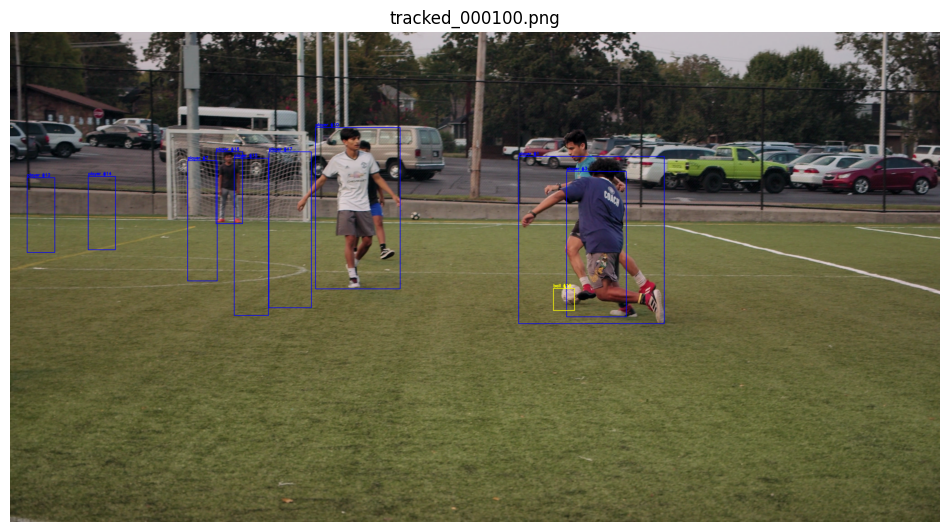

In [7]:
import matplotlib.pyplot as plt
import cv2

img_path = Path("../outputs/day8_tracking/tracked_000100.png").resolve()
img_bgr = cv2.imread(str(img_path))

# BGR -> RGB for matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 7))
plt.imshow(img_rgb)
plt.title(img_path.name)
plt.axis("off")
plt.show()
